In [1]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision.transforms.transforms import ColorJitter, RandomAffine, RandomHorizontalFlip, RandomRotation
from torchsummary import summary

torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading X-Ray Images

In [3]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomAffine(0,shear=10, scale=(0.8, 1.2)),   # Shear - ścinanie, scale - skalowanie obrazu od 80% do 120%
                                    transforms.ColorJitter(brightness = 0.2, contrast=0.2, saturation=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5))])  
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])    

#* Uploading training dataset
training_dataset = datasets.ImageFolder('./chest_xray/test', transform=transform_train)
#* Upload validation dataset
validation_dataset = datasets.ImageFolder('./chest_xray/val', transform=transform)

#* Data loaders
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=16, shuffle=False)


In [4]:
classes = ("NORMAL", "PNEUMONIA")

dataiter = iter(training_loader)   
images , labels = dataiter.next()  

In [7]:
def image_convert(tensor):
    """ Converts tensor to numpy image

    Args:
        tensor ([type]): Tensor image

    Returns:
        [Numpy Image]: Numpy image to plotting
    """
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)                                                #Clip (limit) the values in an array.
    return image

# Plotting training dataset

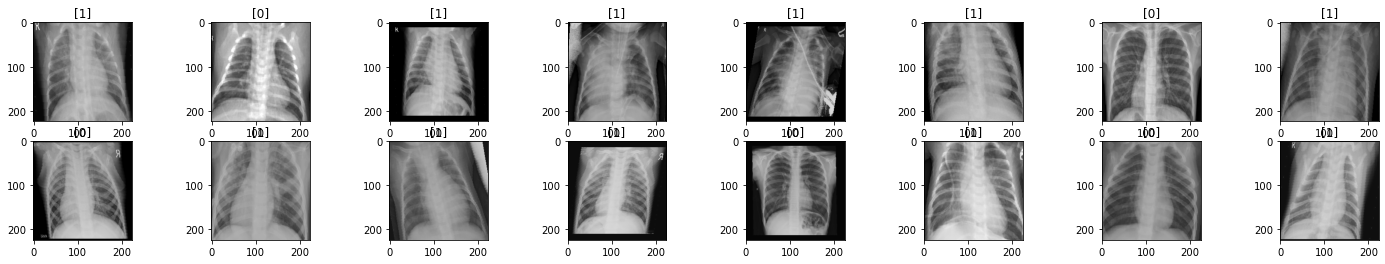

In [8]:
fig = plt.figure(figsize=(25,4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1)
    plt.imshow(image_convert(images[idx]))
    ax.set_title([labels[idx].item()])
    

In [9]:
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False  # Makes all features parameters constant 
    
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer                # Replacing last model layer
model.to(device)

summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

C:\Users\01133904\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [11]:
epochs = 4 

running_loss_history =[]
running_corrects_history = []
val_running_loss_history =[]
val_running_corrects_hisoty =[]


for i in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss +=loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():   
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss +=val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/ len(training_loader.dataset)   # batch
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/ len(validation_loader.dataset)   # batch
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_hisoty.append(val_epoch_acc)

    print(f"Epoch:  {i+1}/{epochs}")
    print("Training loss: {:.4f}, accurancy: {:.4f}".format(epoch_loss, epoch_acc.item()))
    print("Validation loss: {:.4f}, validation accurancy: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

Epoch:  1/4
Training loss: 0.0396, accurancy: 0.6571
Validation loss: 0.0383, validation accurancy: 0.6875
Epoch:  2/4
Training loss: 0.0308, accurancy: 0.7708
Validation loss: 0.0305, validation accurancy: 0.7500
Epoch:  3/4
Training loss: 0.0246, accurancy: 0.8638
Validation loss: 0.0278, validation accurancy: 0.8125
Epoch:  4/4
Training loss: 0.0205, accurancy: 0.8766
Validation loss: 0.0248, validation accurancy: 0.8750


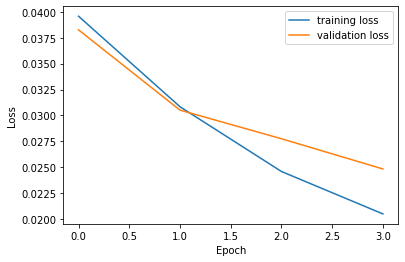

In [32]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label='validation loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

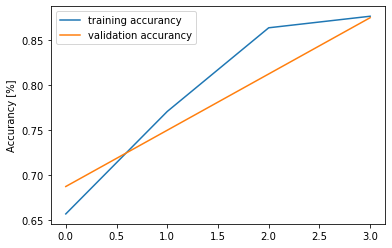

In [28]:

plt.plot(running_corrects_history, label="training accurancy")
plt.plot(val_running_corrects_hisoty, label="validation accurancy")
plt.ylabel("Accurancy [%]")
plt.xlabel("Epoch")
plt.legend()

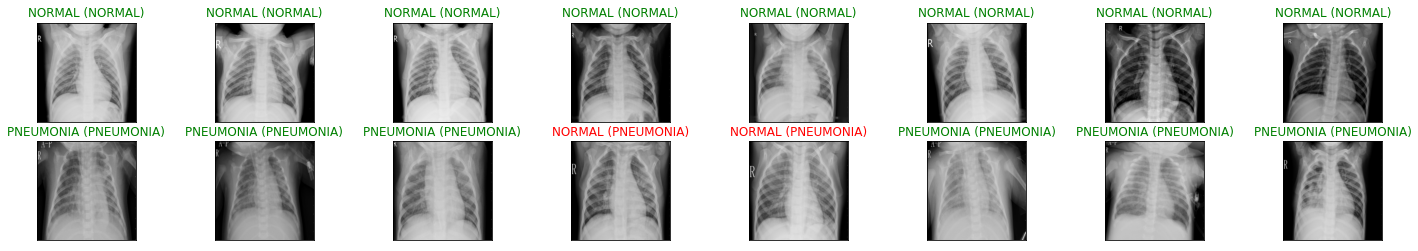

In [14]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(16):
  ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx].cpu()))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))